In [0]:
!pip install pytorch_transformers flair seqeval

In [0]:
#!mkdir -p conll2003
#!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa -O ./conll2003/eng.testa
#!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb -O ./conll2003/eng.testb
#!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train -O ./conll2003/eng.train

In [0]:
import os
import logging
import sys
import torch

In [0]:
# Choosing cuda devices if there are multiple
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [0]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('sequence_tagger_bert')

In [0]:
device = torch.device('cuda')
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

Tesla P100-PCIE-16GB


In [0]:
CACHE_DIR = 'cache'
BATCH_SIZE = 16
PRED_BATCH_SIZE = 100
MAX_LEN = 128
MAX_N_EPOCHS = 5
WEIGHT_DECAY = 0.01
LEARNING_RATE = 5e-5

In [0]:
torch.manual_seed(117)

In [0]:
#from flair.datasets import ColumnCorpus
#data_folder = 'conll2003'
#corpus = ColumnCorpus(data_folder, 
#                      {0 : 'text', 3 : 'ner'},
#                      train_file='eng.train',
#                      test_file='eng.testb',
#                      dev_file='eng.testa')
#
#print(corpus.obtain_statistics())

In [0]:
from flair.datasets import ColumnCorpus
data_folder = 'data'
corpus = ColumnCorpus(data_folder, 
                      {0 : 'idx', 2 : 'text', 3 : 'ner' },
                      train_file='#train_T016.txt',
                      test_file='#test_T016.txt',
                      dev_file='#test_T016.txt')

print(corpus.train[1].to_tagged_string('ner'))
#corpus = corpus.downsample(0.45)
print(corpus.obtain_statistics())


2020-04-14 16:45:05,437 Reading data from data
2020-04-14 16:45:05,440 Train: data/#train_T016.txt
2020-04-14 16:45:05,442 Dev: data/#test_T016.txt
2020-04-14 16:45:05,443 Test: data/#test_T016.txt
group iii iv muscle afferents limit the intramuscular metabolic perturbation during whole body exercise in humans <T016>
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 34211,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 734107,
            "min": 1,
            "max": 168,
            "avg": 21.45821519394347
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 14115,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 302096,
            "min": 1,
            "max": 118,
            "avg": 21.40247963159759
        }
    },
    "DEV": {
      

In [0]:
from bert_sequence_tagger import SequenceTaggerBert, BertForTokenClassificationCustom
from bert_sequence_tagger.bert_utils import make_bert_tag_dict_from_flair_corpus

from pytorch_transformers import BertTokenizer, BertForTokenClassification


bpe_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', 
                                              cache_dir=CACHE_DIR, 
                                              do_lower_case=False)

idx2tag, tag2idx = make_bert_tag_dict_from_flair_corpus(corpus)

model = BertForTokenClassificationCustom.from_pretrained('bert-base-cased', 
                                                         cache_dir=CACHE_DIR, 
                                                         num_labels=len(tag2idx)).cuda()

seq_tagger = SequenceTaggerBert(bert_model=model, bpe_tokenizer=bpe_tokenizer, 
                                idx2tag=idx2tag, tag2idx=tag2idx, max_len=MAX_LEN,
                                pred_batch_size=PRED_BATCH_SIZE)

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at cache/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at cache/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.3d5adf10d3445c36ce131f4c6416aa62e9b58e1af56b97664773f4858a46286e
INFO:pytorch_transformers.modeling_utils:Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers":

In [0]:
print(idx2tag,tag2idx)

['[PAD]', 'O', 'T016'] {'[PAD]': 0, 'O': 1, 'T016': 2}


In [0]:
from bert_sequence_tagger.bert_utils import get_model_parameters, prepare_flair_corpus
from bert_sequence_tagger.model_trainer_bert import ModelTrainerBert
from bert_sequence_tagger.metrics import f1_entity_level, f1_token_level, f1_per_token

from pytorch_transformers import AdamW, WarmupLinearSchedule


train_dataset = prepare_flair_corpus(corpus.train)
val_dataset = prepare_flair_corpus(corpus.dev)

In [0]:
optimizer = AdamW(get_model_parameters(model), 
                  lr=LEARNING_RATE, betas=(0.9, 0.999), 
                  eps =1e-6, weight_decay=0.01, correct_bias=True)
lr_scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0.1, 
                                    t_total=(len(corpus.train) / BATCH_SIZE)*MAX_N_EPOCHS)

In [0]:
trainer = ModelTrainerBert(model=seq_tagger, 
                           optimizer=optimizer, 
                           lr_scheduler=lr_scheduler,
                           train_dataset=train_dataset, 
                           val_dataset=val_dataset,
                           update_scheduler='es',
                           validation_metrics=[f1_entity_level],
                           batch_size=BATCH_SIZE)



trainer.train(epochs=MAX_N_EPOCHS)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:sequence_tagger_bert:Current learning rate: 3.999657416923604e-05
INFO:sequence_tagger_bert:Train loss: 0.0044785093973576575
INFO:sequence_tagger_bert:Validation loss: 0.0008140847222920725
INFO:sequence_tagger_bert:Validation metrics: (0.8067226890756303,)


Epoch:  20%|██        | 1/5 [07:32<30:10, 452.59s/it]

INFO:sequence_tagger_bert:Current learning rate: 2.9992680648265398e-05
INFO:sequence_tagger_bert:Train loss: 0.0013441590049571043
INFO:sequence_tagger_bert:Validation loss: 0.000861937698522217
INFO:sequence_tagger_bert:Validation metrics: (0.8275862068965517,)


Epoch:  40%|████      | 2/5 [15:05<22:37, 452.66s/it]

INFO:sequence_tagger_bert:Current learning rate: 1.9988787127294753e-05
INFO:sequence_tagger_bert:Train loss: 0.000915070700385841
INFO:sequence_tagger_bert:Validation loss: 0.0007570709484061296
INFO:sequence_tagger_bert:Validation metrics: (0.8240343347639485,)


Epoch:  60%|██████    | 3/5 [22:38<15:05, 452.74s/it]

INFO:sequence_tagger_bert:Current learning rate: 9.984893606324108e-06
INFO:sequence_tagger_bert:Train loss: 0.0006938972561888696
INFO:sequence_tagger_bert:Validation loss: 0.0006877122745389846
INFO:sequence_tagger_bert:Validation metrics: (0.835820895522388,)


Epoch:  80%|████████  | 4/5 [30:13<07:33, 453.51s/it]

INFO:sequence_tagger_bert:Current learning rate: 0.0
INFO:sequence_tagger_bert:Train loss: 0.0006084609995821907
INFO:sequence_tagger_bert:Validation loss: 0.0007032770345328802
INFO:sequence_tagger_bert:Validation metrics: (0.8347457627118645,)


Epoch: 100%|██████████| 5/5 [37:46<00:00, 453.38s/it]


In [0]:
test_dataset = prepare_flair_corpus(corpus.test)

_, __, test_metrics = seq_tagger.predict(test_dataset, evaluate=True, 
                                         metrics=[f1_entity_level, f1_token_level, f1_per_token])
logger.info(f'Entity-level f1: {test_metrics[1]}')
logger.info(f'Token-level f1: {test_metrics[2]}')

INFO:sequence_tagger_bert:Entity-level f1: 0.8347457627118645
INFO:sequence_tagger_bert:Token-level f1: 0.8350730688935282


[0.98, 0.73, 0.84]
plotMat: [[0.98, 0.73, 0.84]]
support: [274]


/content/bert_sequence_tagger/plot_classification_report.py:69: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/bert_sequence_tagger/plot_classification_report.py:70: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/content/bert_sequence_tagger/plot_classification_report.py:72: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/bert_sequence_tagger/plot_classification_report.py:73: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


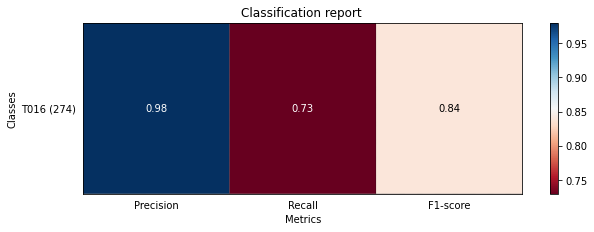

In [0]:
from bert_sequence_tagger.plot_classification_report import plot_classification_report
plot_classification_report(test_metrics[3])

In [0]:
seq_tagger.predict([['We', 'are', 'living', 'in', 'New', 'York', 'city', '.'],
                    ['Satya', 'Narayana', 'Nadella', 'is', 'an', 'engineer', 'and', 'business', 'executive', '.']])

([['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']],
 [7.0453057, 7.595412])

In [0]:
seq_tagger.save_serialize('./bert_model_T016')

In [0]:
from keras.preprocessing.text import text_to_word_sequence
para = "Chikungunya virus ( CHIKV ) is a mosquito. DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis. cftr defect"
para = para.split('.')
para = [text_to_word_sequence(x) for x in para]
print(para)
res,prob = seq_tagger.predict(para)
print(res)

[['chikungunya', 'virus', 'chikv', 'is', 'a', 'mosquito'], ['dctn4', 'as', 'a', 'modifier', 'of', 'chronic', 'pseudomonas', 'aeruginosa', 'infection', 'in', 'cystic', 'fibrosis'], ['cftr', 'defect']]
[['O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O']]


In [0]:
import csv
check_data = open("data/labelled_data_T016.txt")

csv_file = open("data/res_check_T016.csv",'w')
writer = csv.writer(csv_file)

No_of_mistakes = 0
No_of_lines = 0

switch = True
words=[]
tags=[]
for line in check_data.readlines():
  if len(line)==0:
    coninue
  elif switch:
    words = line.split()
    switch = not switch
  else:
    tags = line.split()
    switch = not switch
    res , prob = seq_tagger.predict([words])
    res = res[0]
    No_of_lines += 1
    if No_of_lines % 100 == 0:
      print("Line = ",No_of_lines)
    if res != tags:
      writer.writerow(words)
      writer.writerow(tags)
      writer.writerow(res)
      writer.writerow([''])
      No_of_mistakes +=1
      if No_of_mistakes % 10 == 0:
        print('Mistakes = ',No_of_mistakes)
